In [1]:
# Import libraries

# Pandas for data handling
import pandas # https://pandas.pydata.org/
# from pandas.plotting import scatter_matrix

# pretty tables
from IPython.display import display

# NumPy for numerical computing
import numpy # https://numpy.org/

# MatPlotLib+Seaborn for visualization
import matplotlib.pyplot as pl  # https://matplotlib.org/
import seaborn as sns

# assessment
from sklearn import model_selection # for model comparisons
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score

# algorithms
from sklearn import tree
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier


# data preprocessing / feature selection
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# combining
from sklearn.pipeline import make_pipeline



In [2]:
print('Loading data from file ...')  # Now let's load the data
dataset = pandas.read_csv('winequality-white.csv') # default is header=infer, change if column names are not in first row
print('done \n')

print('Removing rows with missing data ...')  # Make things simple
dataset = dataset.dropna()  # default is to drop any row that contains at least one missing value
print('done \n')

Loading data from file ...
done 

Removing rows with missing data ...
done 



In [3]:
# Let's set up a problem: Can we predict 'quality' using these three features: 'fixed acidity', 'alcohol', 'pH' ?

print('Reading list of problem variables X and Y...')
X_name = [ 'fixed acidity', 'alcohol', 'pH' ] # columns to focus on as predictors
X = dataset[X_name]   # only keep these columns as features
y_name = 'quality'     # column to focus on as target
y = dataset[y_name]   # only keep this column as label 
print('done \n')

# Split-out test dataset

# We reset the random number seed before each run to ensure that the evaluation of each algorithm is performed using exactly the same data splits. It ensures the results are directly comparable.
seed = 27

# Train, test split
print('Partitioning data into parts: formative (for development) and summative (for testing) ...')
test_size = 0.20   # means 20 percent

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=test_size, random_state=seed)
print('done \n')

Reading list of problem variables X and Y...
done 

Partitioning data into parts: formative (for development) and summative (for testing) ...
done 



In [4]:
#Will take the two models that have been chosen to be tested
print('Reading list of algorithms to train ...')
models = []
models.append(( 'MLP', MLPClassifier(hidden_layer_sizes=(100,), 
                                     activation='relu',  
                                     ) )) #Basic default for all
print('done \n')

Reading list of algorithms to train ...
done 



In [5]:
print('Reading list of scoring methods to use during model development ...')
scoring = 'accuracy'
print('done \n')

Reading list of scoring methods to use during model development ...
done 



In [6]:
# Now it is time to develop (train and validate) the models on the formative data set there will be two models

k4folds = 5   # This will split our formative dataset into five parts;
results = []
names = []
for name, model in models:   # Select each model in turn
    print(" ++ NOW WORKING ON ALGORITHM %s ++" % name)
    print("Splitting data into %s folds" % k4folds)
    kfold = model_selection.KFold(n_splits=k4folds, random_state=seed, shuffle=True)   # fit the model using four parts at a time and then validate it on the oher part that was set aside; and repeat five times.
    print("Training model on each split")
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "algorithm %s %s results: mean = %f (std = %f)" % (name, scoring, cv_results.mean(), cv_results.std())
    print(msg)
    
print('done \n') 

 ++ NOW WORKING ON ALGORITHM MLP ++
Splitting data into 5 folds
Training model on each split
algorithm MLP accuracy results: mean = 0.477541 (std = 0.009491)
done 



In [13]:
#Tuning the MLP model
selected_model = MLPClassifier()
hyperparameters = {'hidden_layer_sizes':[(100,), (100, 100), (100, 50), (50, 50)], 'activation':['identity', 'logistic', 'tanh', 'relu'] }



print("Now tuning hyperparameters...")
mlp = GridSearchCV(selected_model, hyperparameters, cv=5, scoring=scoring)

   
mlp.fit(X_train, y_train)

print("Best hyperparameters found on development set:")
print(mlp.best_params_)
print("Grid scores on development set:")
means = mlp.cv_results_['mean_test_score']
stds = mlp.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, mlp.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
        % (mean, std * 2, params))
print('done \n')

tuned_model = mlp.best_estimator_

Now tuning hyperparameters...


/project/dsi/apps/anaconda3/python-3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Best hyperparameters found on development set:
{'activation': 'tanh', 'hidden_layer_sizes': (100, 100)}
Grid scores on development set:
0.479 (+/-0.031) for {'activation': 'identity', 'hidden_layer_sizes': (100,)}
0.478 (+/-0.029) for {'activation': 'identity', 'hidden_layer_sizes': (100, 100)}
0.474 (+/-0.011) for {'activation': 'identity', 'hidden_layer_sizes': (100, 50)}
0.465 (+/-0.027) for {'activation': 'identity', 'hidden_layer_sizes': (50, 50)}
0.488 (+/-0.027) for {'activation': 'logistic', 'hidden_layer_sizes': (100,)}
0.482 (+/-0.022) for {'activation': 'logistic', 'hidden_layer_sizes': (100, 100)}
0.490 (+/-0.025) for {'activation': 'logistic', 'hidden_layer_sizes': (100, 50)}
0.483 (+/-0.023) for {'activation': 'logistic', 'hidden_layer_sizes': (50, 50)}
0.479 (+/-0.022) for {'activation': 'tanh', 'hidden_layer_sizes': (100,)}
0.490 (+/-0.019) for {'activation': 'tanh', 'hidden_layer_sizes': (100, 100)}
0.485 (+/-0.012) for {'activation': 'tanh', 'hidden_layer_sizes': (100

In [15]:
print('Reading list of algorithms to train ...')
models = []
models.append(( 'lbfgs100', MLPClassifier(hidden_layer_sizes=(100, 100), 
                                     activation='tanh',
                                     solver='lbfgs',
                                     max_iter=100,
                                     ) )) 
models.append(( 'sgb100', MLPClassifier(hidden_layer_sizes=(100, 100), 
                                     activation='tanh',
                                     solver='sgd',
                                     max_iter=100,
                                     ) )) 
models.append(( 'lbfgs50', MLPClassifier(hidden_layer_sizes=(100, 100), 
                                     activation='tanh',
                                     solver='lbfgs',
                                     max_iter=50,
                                     ) )) 
models.append(( 'sgb50', MLPClassifier(hidden_layer_sizes=(100, 100), 
                                     activation='tanh',
                                     solver='sgb',
                                     max_iter=50,
                                     ) )) 
print('done \n')

Reading list of algorithms to train ...
done 



In [16]:
print('Reading list of scoring methods to use during model development ...')
scoring = 'accuracy'
print('done \n')

Reading list of scoring methods to use during model development ...
done 



In [17]:
# Now it is time to develop (train and validate) the models on the formative data set there will be two models

k4folds = 5   # This will split our formative dataset into five parts;
results = []
names = []
for name, model in models:   # Select each model in turn
    print(" ++ NOW WORKING ON ALGORITHM %s ++" % name)
    print("Splitting data into %s folds" % k4folds)
    kfold = model_selection.KFold(n_splits=k4folds, random_state=seed, shuffle=True)   # fit the model using four parts at a time and then validate it on the oher part that was set aside; and repeat five times.
    print("Training model on each split")
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "algorithm %s %s results: mean = %f (std = %f)" % (name, scoring, cv_results.mean(), cv_results.std())
    print(msg)
    
print('done \n') 

 ++ NOW WORKING ON ALGORITHM lbfgs100 ++
Splitting data into 5 folds
Training model on each split


/project/dsi/apps/anaconda3/python-3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/project/dsi/apps/anaconda3/python-3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/project/dsi/apps/anaconda3/python-3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: Converg

algorithm lbfgs100 accuracy results: mean = 0.490048 (std = 0.007421)
 ++ NOW WORKING ON ALGORITHM sgb100 ++
Splitting data into 5 folds
Training model on each split


/project/dsi/apps/anaconda3/python-3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/project/dsi/apps/anaconda3/python-3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/project/dsi/apps/anaconda3/python-3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/project/dsi/apps/anaconda3/python-3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converge

algorithm sgb100 accuracy results: mean = 0.483158 (std = 0.012986)
 ++ NOW WORKING ON ALGORITHM lbfgs50 ++
Splitting data into 5 folds
Training model on each split


/project/dsi/apps/anaconda3/python-3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/project/dsi/apps/anaconda3/python-3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/project/dsi/apps/anaconda3/python-3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: Converg

algorithm lbfgs50 accuracy results: mean = 0.488265 (std = 0.011765)
 ++ NOW WORKING ON ALGORITHM sgb50 ++
Splitting data into 5 folds
Training model on each split
algorithm sgb50 accuracy results: mean = nan (std = nan)
done 



/project/dsi/apps/anaconda3/python-3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/project/dsi/apps/anaconda3/python-3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/project/dsi/ap

/project/dsi/apps/anaconda3/python-3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 ++++ Detailed classification report for the selected model ++++ 
Algorithm MLPClassifier(activation='tanh', hidden_layer_sizes=(100, 100), max_iter=100,
              solver='lbfgs') 
This model was trained and tuned on the development set using CV.
The following results are computed on the separate test set:


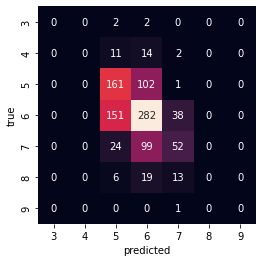


 clasification report:
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00        27
           5       0.45      0.61      0.52       264
           6       0.54      0.60      0.57       471
           7       0.49      0.30      0.37       175
           8       0.00      0.00      0.00        38
           9       0.00      0.00      0.00         1

    accuracy                           0.51       980
   macro avg       0.21      0.22      0.21       980
weighted avg       0.47      0.51      0.48       980



done 



/project/dsi/apps/anaconda3/python-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/project/dsi/apps/anaconda3/python-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/project/dsi/apps/anaconda3/python-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

In [18]:
model1 = MLPClassifier(hidden_layer_sizes=(100, 100), 
                       activation='tanh',
                       solver='lbfgs',
                       max_iter=100,
                       )
model1.fit(X_train, y_train)
predictions = model1.predict(X_test)
print(" ++++ Detailed classification report for the selected model ++++ " )
print("Algorithm %s " % model1)
print("This model was trained and tuned on the development set using CV.")
print("The following results are computed on the separate test set:")

predictions = model1.predict(X_test)
cm = confusion_matrix(y_test, predictions)
df_cm = pandas.DataFrame(cm, columns=numpy.unique(y_test), index = numpy.unique(y_test))
sns.heatmap(df_cm, square=True, annot=True, fmt='d', cbar=False )
pl.xlabel('predicted')
pl.ylabel('true')
pl.show()

print('\n clasification report:\n', classification_report(y_test, predictions))
print('\n')        
print('done \n')

In [20]:
#Comparison of DT model to scaled model

scaled_DT = make_pipeline( MinMaxScaler(), DecisionTreeClassifier(criterion='gini', max_depth=8 ) )  
scaled_DT.fit(X_train, y_train)
print("Detailed classification report:")
print('\n')
y_true, y_pred = y_test, scaled_DT.predict(X_test)
print(classification_report(y_true, y_pred))
print('done \n')

Detailed classification report:


              precision    recall  f1-score   support

           3       0.00      0.00      0.00         4
           4       0.67      0.07      0.13        27
           5       0.47      0.55      0.51       264
           6       0.55      0.64      0.59       471
           7       0.53      0.35      0.42       175
           8       0.25      0.03      0.05        38
           9       0.00      0.00      0.00         1

    accuracy                           0.52       980
   macro avg       0.35      0.24      0.24       980
weighted avg       0.51      0.52      0.50       980

done 



/project/dsi/apps/anaconda3/python-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/project/dsi/apps/anaconda3/python-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/project/dsi/apps/anaconda3/python-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta